In [ ]:
# Rsearch Assistant, London Metropolitan University
#
# This is an example fo Semantic Segmentation.
# Open Database V7:: https://storage.googleapis.com/openimages/web/index.html
# I have tried to use Ducks Segmentation
# ******************************************************************************

# **Runtime Librarys Install**

In [ ]:
# install requirements

!pip install boto3==1.33.3
!pip install tqdm==4.66.1
!pip install requests==2.31.0
!pip install pandas==2.1.3
!pip install opencv-python==4.8.1.78

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.4
    Uninstalling tqdm-4.66.4:
      Successfully uninstalled tqdm-4.66.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.1.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━

# **Function to Generate Polygon Data as Label from Segmented Image**

It starts downloading data from Open Databse <br/>
There is a function mask_to_polygon, it converts Masked Image to Label Image

In [ ]:
import ast
import os
import shutil
import argparse
import zipfile
import time

import requests
from requests.adapters import Retry

import pandas as pd
import cv2


def mask_to_polygon(image_path, class_id):
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    H, W = mask.shape
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convert the contours to polygons
    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:
            polygon = []
            for point in cnt:
                x, y = point[0]
                polygon.append(x / W)
                polygon.append(y / H)
            polygons.append(polygon)

    ret = ''

    for polygon in polygons:
        for p_, p in enumerate(polygon):
            if p_ == len(polygon) - 1:
                ret = ret + '{}\n'.format(p)
            elif p_ == 0:
                ret = ret + str(class_id) + ' {} '.format(p)
            else:
                ret = ret + '{} '.format(p)
    return ret


def process(classes, data_out_dir):

    train_mask_data_url = 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv'
    val_mask_data_url = 'https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv'
    test_mask_data_url = 'https://storage.googleapis.com/openimages/v5/test-annotations-object-segmentation.csv'

    downloader_url = 'https://raw.githubusercontent.com/openimages/dataset/master/downloader.py'
    class_names_all_url = 'https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions.csv'
    class_ids_sem_seg_url = 'https://storage.googleapis.com/openimages/v7/oidv7-classes-segmentation.txt'

    for url in [train_mask_data_url, val_mask_data_url, test_mask_data_url, class_ids_sem_seg_url, class_names_all_url,
                downloader_url]:
        if not os.path.exists(url.split('/')[-1]):

            print('downloading {}...'.format(url.split('/')[-1]))

            r = requests.get(url)
            with open(url.split('/')[-1], 'wb') as f:
                f.write(r.content)

    class_ids = []

    classes_all = pd.read_csv(class_names_all_url.split('/')[-1])

    with open(class_ids_sem_seg_url.split('/')[-1], 'r') as f:
        classes_sem_seg = [l[:-1] for l in f.readlines() if len(l) > 1]
        f.close()

    for class_ in classes:
        if class_ not in list(classes_all['DisplayName']):
            raise Exception('Class name not found: {}'.format(class_))
        class_index = list(classes_all['DisplayName']).index(class_)
        class_id_ = classes_all['LabelName'].iloc[class_index]
        if class_id_ in classes_sem_seg:
            class_ids.append(class_id_)
        else:
            raise Exception('Class name not found: {}'.format(class_))


    image_list_file_path = os.path.join('.', 'image_list_file')
    if os.path.exists(image_list_file_path):
        os.remove(image_list_file_path)

    image_list_file_list = []
    mask_paths = []
    for j, url in enumerate([train_mask_data_url, val_mask_data_url, test_mask_data_url]):
        filename = url.split('/')[-1]
        with open(filename, 'r') as f:
            line = f.readline()
            while len(line) != 0:
                mask_path, id, class_name, _, _, _, _, _, _, _ = line.split(',')[:13]
                if class_name in class_ids:
                    mask_paths.append(['train', 'validation', 'test'][j] + '/' + mask_path)
                    if id not in image_list_file_list:
                        image_list_file_list.append(id)
                        with open(image_list_file_path, 'a') as fw:
                            fw.write('{}/{}\n'.format(['train', 'validation', 'test'][j], id))
                            fw.close()
                line = f.readline()

            f.close()

    out_dir = './.out'
    shutil.rmtree(out_dir, ignore_errors=True)
    os.makedirs(out_dir)
    # os.system('python downloader.py {} --download_folder={}'.format(image_list_file_path, out_dir))
    !python downloader.py ./image_list_file --download_folder=./.out

    # download all masks
    out_masks_dir_ = './.out_masks_all'
    shutil.rmtree(out_masks_dir_, ignore_errors=True)
    os.makedirs(out_masks_dir_)
    for set_ in ['train', 'validation', 'test']:
        dir_ = os.path.join(out_masks_dir_, set_)
        # if os.path.exists(dir_):
        #     shutil.rmtree(dir_)
        os.makedirs(dir_, exist_ok=True)
        for k in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  'a', 'b', 'c', 'd', 'e', 'f']:
            url = 'https://storage.googleapis.com/openimages/v5/{}-masks/{}-masks-{}.zip'.format(set_, set_, k)

            if not os.path.exists('{}-masks-{}.zip'.format(set_, k)):

                print('downloading {}...'.format('{}-masks-{}.zip'.format(set_, k)))

                for retry in range(1, 10):
                    retry_because_of_timeout = False
                    try:
                        r = requests.get(url, timeout=5)
                    except Exception as e:
                        retry_because_of_timeout = True
                        print(e)

                    if retry_because_of_timeout:
                        print('retry', retry, url.split('/')[-1])
                        time.sleep(retry * 2 + 1)
                    else:
                        break

                with open(url.split('/')[-1], 'wb') as f:
                    f.write(r.content)

            with zipfile.ZipFile(url.split('/')[-1], 'r') as zip_ref:
                zip_ref.extractall(dir_ + '/')

            os.remove(url.split('/')[-1])

            for img_path_ in os.listdir(dir_):
                if '{}/{}'.format(set_, img_path_) not in mask_paths:
                    os.remove(os.path.join(dir_, img_path_))

    for set_ in ['train', 'validation', 'test']:
        for dir_ in [os.path.join(data_out_dir, 'images', set_),
                     os.path.join(data_out_dir, 'labels', set_)]:
            if os.path.exists(dir_):
                shutil.rmtree(dir_)
            os.makedirs(dir_)

    for mask_path in mask_paths:
        set_ = mask_path.split(os.sep)[0]
        image_id = mask_path.split(os.sep)[1][:-4][:16]
        label_name = mask_path.split(os.sep)[1][:-4][17:-9]
        print(mask_path, set_, image_id, label_name, os.path.exists(os.path.join(out_dir, '{}.jpg'.format(image_id))))
        if os.path.exists(os.path.join(out_dir, '{}.jpg'.format(image_id))):
            shutil.move(os.path.join(out_dir, '{}.jpg'.format(image_id)),
                        os.path.join(data_out_dir, 'images', set_, '{}.jpg'.format(image_id)))

        if os.path.exists(os.path.join(data_out_dir, 'images', set_, '{}.jpg'.format(image_id))):
            with open(os.path.join(data_out_dir, 'labels', set_, '{}.txt'.format(image_id)), 'a') as f:
                f.write('{}'.format(mask_to_polygon(os.path.join(out_masks_dir_, set_, mask_path.split(os.sep)[1]),
                                                    int([c.replace('/', '') for c in class_ids].index(label_name)))))
                f.close()

    shutil.rmtree(out_dir, ignore_errors=True)
    shutil.rmtree(out_masks_dir_, ignore_errors=True)


# **Start Downloading Data from Openimages based on provided Class name, Downloading Dick Images**

In [ ]:
classes = ['Duck']  # list containing all the classes you will download from the open images dataset v7

out_dir = './data'

process(classes, out_dir)

Streaming output truncated to the last 5000 lines.
train/af48a67357f9caca_m09ddx_90c8d5c8.png train af48a67357f9caca m09ddx False
train/2bc5dd9908ec88a3_m09ddx_ec82afbb.png train 2bc5dd9908ec88a3 m09ddx True
train/ee2b9c2d7e9b1c29_m09ddx_805b0262.png train ee2b9c2d7e9b1c29 m09ddx False
train/00d4d62e8320e24f_m09ddx_c1744b8c.png train 00d4d62e8320e24f m09ddx True
train/ab5c590ab0646749_m09ddx_a27067e4.png train ab5c590ab0646749 m09ddx False
train/8cc8ab94634278cf_m09ddx_3363b640.png train 8cc8ab94634278cf m09ddx False
train/098e46eaf3f14fbd_m09ddx_b8b782fb.png train 098e46eaf3f14fbd m09ddx False
train/211ef9e7e8a5e939_m09ddx_0b184913.png train 211ef9e7e8a5e939 m09ddx False
train/be28efa9d3766ffa_m09ddx_9045ad67.png train be28efa9d3766ffa m09ddx False
train/0fec80dfb3a4ed1e_m09ddx_ecd4f2d2.png train 0fec80dfb3a4ed1e m09ddx True
train/8dcccbca496b40f4_m09ddx_4216cb6a.png train 8dcccbca496b40f4 m09ddx False
train/1c234c8fe0fb2cb3_m09ddx_04c4c705.png train 1c234c8fe0fb2cb3 m09ddx False
trai

# **Zip the Downloaded for Future Usage so that I do not need to Download Data everytime**

In [ ]:
# zip the data directory

!zip -r data.zip /content/data

Streaming output truncated to the last 5000 lines.
  adding: content/data/labels/train/0e9218ed0d47e8c0.txt (deflated 83%)
  adding: content/data/labels/train/047bbaaa485463a3.txt (deflated 82%)
  adding: content/data/labels/train/a2041c9fd2291315.txt (deflated 81%)
  adding: content/data/labels/train/e4f82bd7b3b1746a.txt (deflated 83%)
  adding: content/data/labels/train/1af60feda5a2204f.txt (deflated 84%)
  adding: content/data/labels/train/f8ad8905e6f42320.txt (deflated 83%)
  adding: content/data/labels/train/894eaa4dbc482ce5.txt (deflated 81%)
  adding: content/data/labels/train/21f28b9a129e31e9.txt (deflated 84%)
  adding: content/data/labels/train/cb213812e65316e1.txt (deflated 79%)
  adding: content/data/labels/train/5e980d80d03ad363.txt (deflated 81%)
  adding: content/data/labels/train/99108f5d2b723cff.txt (deflated 83%)
  adding: content/data/labels/train/985a8519e75f9e1d.txt (deflated 85%)
  adding: content/data/labels/train/f5e482bcda790149.txt (deflated 85%)
  adding: con

# **Mounting Google Drive so that Data can be saved or pushed to Google Drive for later usage**

In [ ]:
# mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# copy data to your Google Drive
#!scp '/content/data.zip' '/content/gdrive/My Drive/data.zip'


In [ ]:
#Downloading open dataset from google drive
!mkdir /content/data
!scp /content/gdrive/MyDrive/open_image_data.zip /content/data.zip

In [ ]:
!unzip /content/data.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/content/data/labels/train/0e9218ed0d47e8c0.txt  
  inflating: /content/data/content/data/labels/train/047bbaaa485463a3.txt  
  inflating: /content/data/content/data/labels/train/a2041c9fd2291315.txt  
  inflating: /content/data/content/data/labels/train/e4f82bd7b3b1746a.txt  
  inflating: /content/data/content/data/labels/train/1af60feda5a2204f.txt  
  inflating: /content/data/content/data/labels/train/f8ad8905e6f42320.txt  
  inflating: /content/data/content/data/labels/train/894eaa4dbc482ce5.txt  
  inflating: /content/data/content/data/labels/train/21f28b9a129e31e9.txt  
  inflating: /content/data/content/data/labels/train/cb213812e65316e1.txt  
  inflating: /content/data/content/data/labels/train/5e980d80d03ad363.txt  
  inflating: /content/data/content/data/labels/train/99108f5d2b723cff.txt  
  inflating: /content/data/content/data/labels/train/985a8519e75f9e1d.txt  
  inflating: /content/data/content/da

# **Installing Yolo**

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 kB 18.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

# **Writing Configuration file for Yolov8 that will be used for training**

In [ ]:
%%writefile /content/data/dataset.yaml
train: /content/data/images/train
val: /content/data/images/validation

nc: 1
names: ['Duck']

Writing /content/data/dataset.yaml


Yolov8 Model training using Segmentation

In [ ]:
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('yolov8n-seg.pt')  # You can choose yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt

# Train the model
model.train(data='/content/data/dataset.yaml', epochs=30, imgsz=640, batch=10)

100%|██████████| 6.73M/6.73M [00:00<00:00, 265MB/s]


Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data/dataset.yaml, epochs=30, time=None, patience=100, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 321MB/s]


AMP: checks passed ✅


train: Scanning /content/data/labels/train... 3965 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3965/3965 [00:05<00:00, 667.59it/s]


train: New cache created: /content/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/data/labels/validation... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<00:00, 367.06it/s]

val: New cache created: /content/data/labels/validation.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.00046875), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.17G      1.062      1.909      1.475      1.139         14        640: 100%|██████████| 397/397 [00:56<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all         65        137      0.779      0.744      0.785      0.477      0.762      0.759      0.778      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.95G       1.12       1.98      1.223      1.182         14        640: 100%|██████████| 397/397 [00:49<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

                   all         65        137      0.816      0.744      0.792      0.509        0.8      0.729      0.769      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.93G      1.124      1.976      1.155       1.19         30        640: 100%|██████████| 397/397 [00:49<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

                   all         65        137      0.777      0.636      0.773      0.466      0.764       0.62      0.737       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.92G       1.11      1.971      1.108      1.183         29        640: 100%|██████████| 397/397 [00:49<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]

                   all         65        137      0.848      0.657       0.75      0.517      0.833      0.693      0.752      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.94G      1.056       1.89      1.041      1.168         18        640: 100%|██████████| 397/397 [00:49<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]

                   all         65        137      0.807      0.723      0.809      0.556      0.815      0.709      0.808      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.06G      1.035      1.835      1.023      1.151         38        640: 100%|██████████| 397/397 [00:48<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

                   all         65        137      0.869      0.728      0.815      0.577      0.861      0.721      0.792      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.03G      1.013       1.81     0.9809      1.133         23        640: 100%|██████████| 397/397 [00:50<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.64it/s]

                   all         65        137      0.925      0.723      0.855      0.589      0.859      0.737       0.85      0.611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.99G     0.9843      1.744     0.9436      1.126         10        640: 100%|██████████| 397/397 [00:50<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

                   all         65        137      0.853      0.762      0.862      0.629      0.879      0.752      0.862      0.615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.06G     0.9663      1.733     0.9261      1.111         16        640: 100%|██████████| 397/397 [00:49<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all         65        137      0.864      0.744      0.828      0.606      0.864      0.744      0.831      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.04G     0.9438      1.686     0.8952      1.099         22        640: 100%|██████████| 397/397 [00:49<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         65        137      0.872      0.796      0.866      0.642      0.872      0.796      0.863      0.634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30         2G     0.9279      1.656     0.8731      1.096         21        640: 100%|██████████| 397/397 [00:51<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]

                   all         65        137      0.885      0.759      0.864      0.639      0.885      0.759      0.854      0.627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.93G     0.9148      1.636      0.859      1.089         21        640: 100%|██████████| 397/397 [00:48<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]

                   all         65        137       0.87      0.779      0.857      0.616      0.904      0.759      0.853      0.627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.96G     0.9019      1.595     0.8404      1.081         37        640: 100%|██████████| 397/397 [00:48<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all         65        137       0.85      0.828      0.878      0.657      0.835      0.814      0.856      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.06G     0.8927      1.588     0.8237      1.069         16        640: 100%|██████████| 397/397 [00:50<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

                   all         65        137      0.911      0.774      0.876       0.63      0.911      0.774      0.871      0.644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.87G     0.8705      1.531     0.7963      1.065         17        640: 100%|██████████| 397/397 [00:48<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

                   all         65        137      0.843      0.803      0.838      0.625      0.891      0.774      0.852       0.63



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.99G     0.8581      1.536     0.8017      1.054         12        640: 100%|██████████| 397/397 [00:49<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

                   all         65        137      0.883      0.752      0.865      0.647      0.902      0.739      0.868      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30         2G     0.8468      1.548     0.7864      1.055         23        640: 100%|██████████| 397/397 [00:49<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

                   all         65        137      0.873      0.796      0.865      0.654      0.884       0.78      0.861      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30         2G     0.8468      1.517      0.764      1.052         13        640: 100%|██████████| 397/397 [00:50<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.57it/s]

                   all         65        137      0.895       0.81      0.878       0.67      0.893      0.796      0.874       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30         2G     0.8279      1.486     0.7522      1.042         23        640: 100%|██████████| 397/397 [00:48<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all         65        137      0.893      0.788      0.888      0.679      0.898      0.775      0.884      0.684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.91G     0.8163      1.463     0.7329      1.039         29        640: 100%|██████████| 397/397 [00:48<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

                   all         65        137      0.897      0.781      0.874      0.664      0.853       0.81      0.873       0.66


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.92G     0.7957        1.4     0.7161       1.04          7        640: 100%|██████████| 397/397 [00:47<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

                   all         65        137      0.905      0.803      0.886      0.679      0.897      0.796      0.886       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.96G     0.7708      1.363     0.6879      1.025         21        640: 100%|██████████| 397/397 [00:45<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]

                   all         65        137      0.909      0.766      0.865       0.66      0.913       0.77      0.863      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.95G     0.7608      1.334     0.6701      1.019          6        640: 100%|██████████| 397/397 [00:44<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all         65        137      0.901      0.801      0.888      0.693       0.91      0.808      0.891      0.698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.89G     0.7468      1.307     0.6576      1.009         11        640: 100%|██████████| 397/397 [00:45<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]

                   all         65        137      0.888      0.813       0.88      0.679      0.888      0.813      0.879      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.98G     0.7349      1.299     0.6445      1.008          6        640: 100%|██████████| 397/397 [00:45<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.62it/s]

                   all         65        137       0.87      0.832      0.892      0.698      0.871      0.836       0.89      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.95G     0.7215      1.267     0.6374     0.9939         14        640: 100%|██████████| 397/397 [00:45<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

                   all         65        137       0.89      0.826      0.887      0.686       0.89      0.826      0.883      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.87G     0.7075      1.245      0.617     0.9861          6        640: 100%|██████████| 397/397 [00:45<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

                   all         65        137      0.924      0.796      0.883      0.685      0.928      0.803       0.89      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.89G     0.6911      1.224     0.6079     0.9774         16        640: 100%|██████████| 397/397 [00:45<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

                   all         65        137      0.932      0.803       0.89      0.688      0.868      0.839      0.882       0.68



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.92G     0.6873      1.213      0.593      0.979         34        640: 100%|██████████| 397/397 [00:45<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all         65        137      0.927      0.825      0.895      0.705      0.919      0.818      0.887       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.95G      0.675      1.202      0.581     0.9701         13        640: 100%|██████████| 397/397 [00:45<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all         65        137      0.893      0.847      0.897      0.715      0.927       0.81      0.889      0.701



30 epochs completed in 0.416 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


                   all         65        137      0.893      0.847      0.897      0.716      0.926       0.81      0.889      0.701
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78379005b5b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

# **Make a Zip file of Yolo v8 Trained data so that I can further research even when Google Colab Delete the Result Session**

In [ ]:
import shutil

# Specify the directory you want to zip
directory_to_zip = 'runs/segment/train'
output_zip_file = 'run.zip'

# Use shutil.make_archive to zip the directory
shutil.make_archive(output_zip_file.replace('.zip', ''), 'zip', directory_to_zip)

'/content/run.zip'

In [ ]:
from google.colab import files

# Download the zip file to your local machine
files.download(output_zip_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image


# **To View Original Data that has been Downloaded**

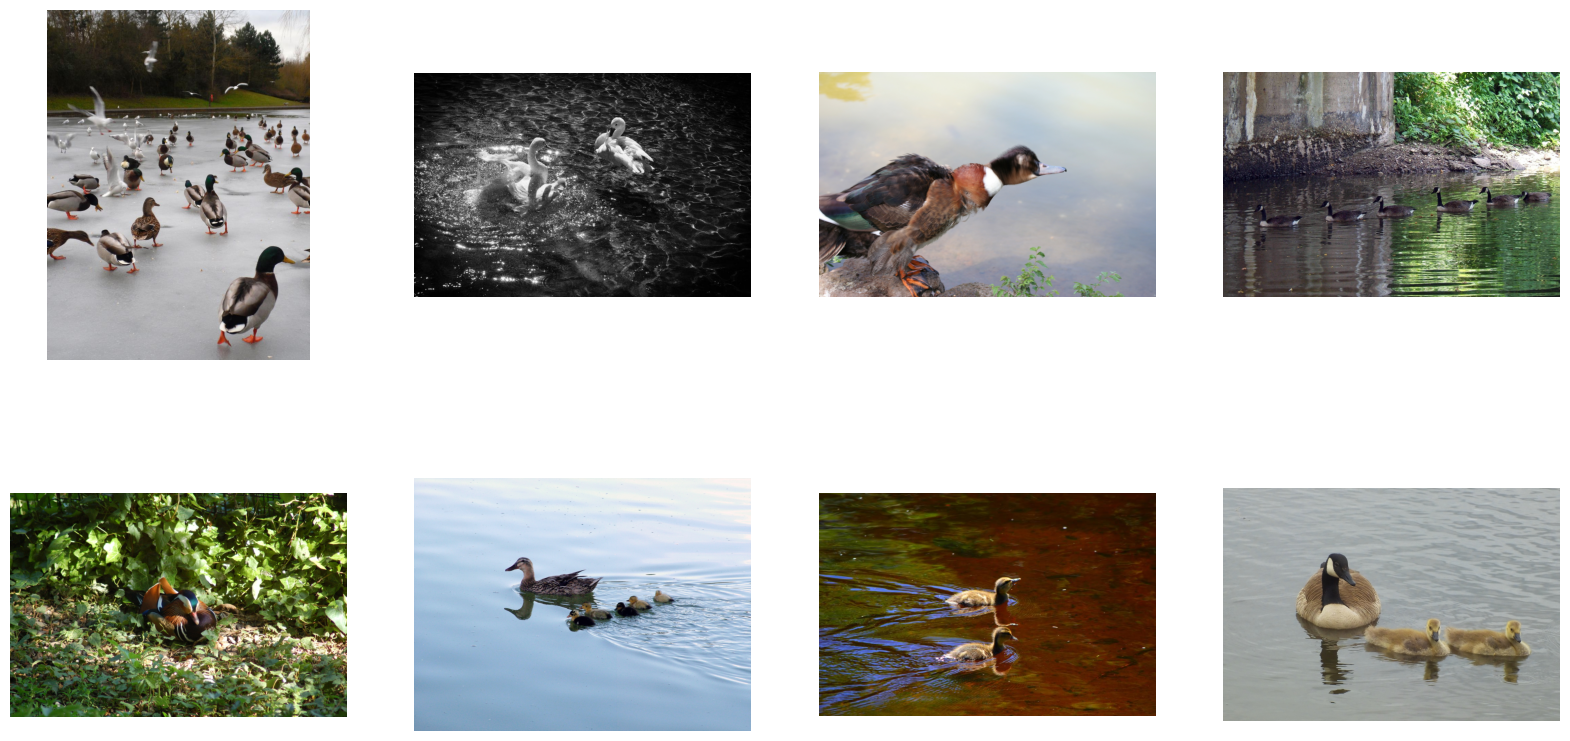

In [ ]:
# Path to the images folder
images_folder = f'/content/data/images/train'

# Function to load and display images
def display_images(image_paths):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Get a list of all image paths in the training folder
image_paths = [os.path.join(images_folder, filename) for filename in os.listdir(images_folder) if filename.endswith('.jpg')]

# Shuffle the list of image paths
random.shuffle(image_paths)

# Select 8 random image paths
random_image_paths = image_paths[:8]

# Display the random images
display_images(random_image_paths)

# **Analyzing Model Training Details - Results**

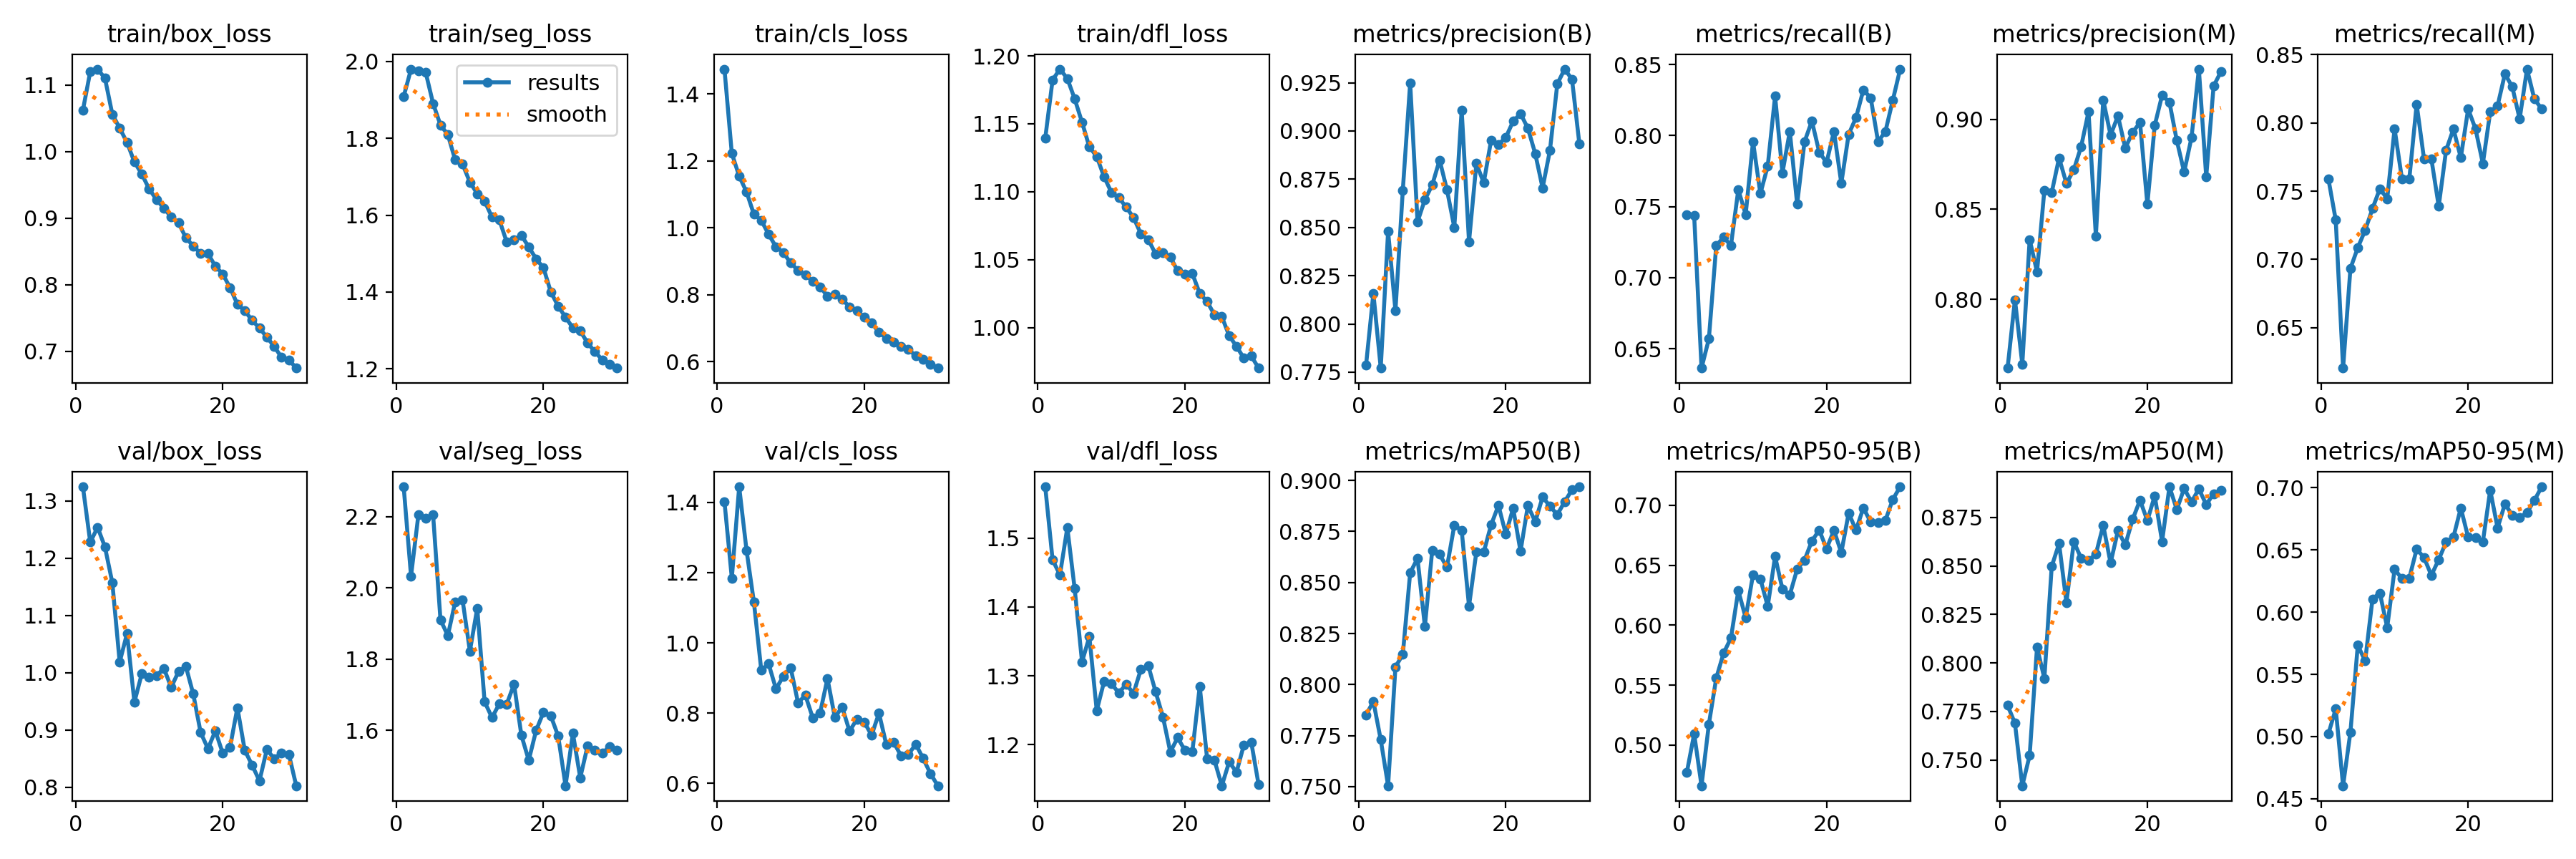

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# List all files in the directory
save_dir = 'runs/segment/train'
files = os.listdir(save_dir)


# Display an image
#image_path = os.path.join(save_dir, 'results.png')  # replace with actual image file name
#img = mpimg.imread(image_path)
#imgplot = plt.imshow(img)
#plt.show()

Image(filename=f"/content/runs/segment/train/results.png", width=1000)

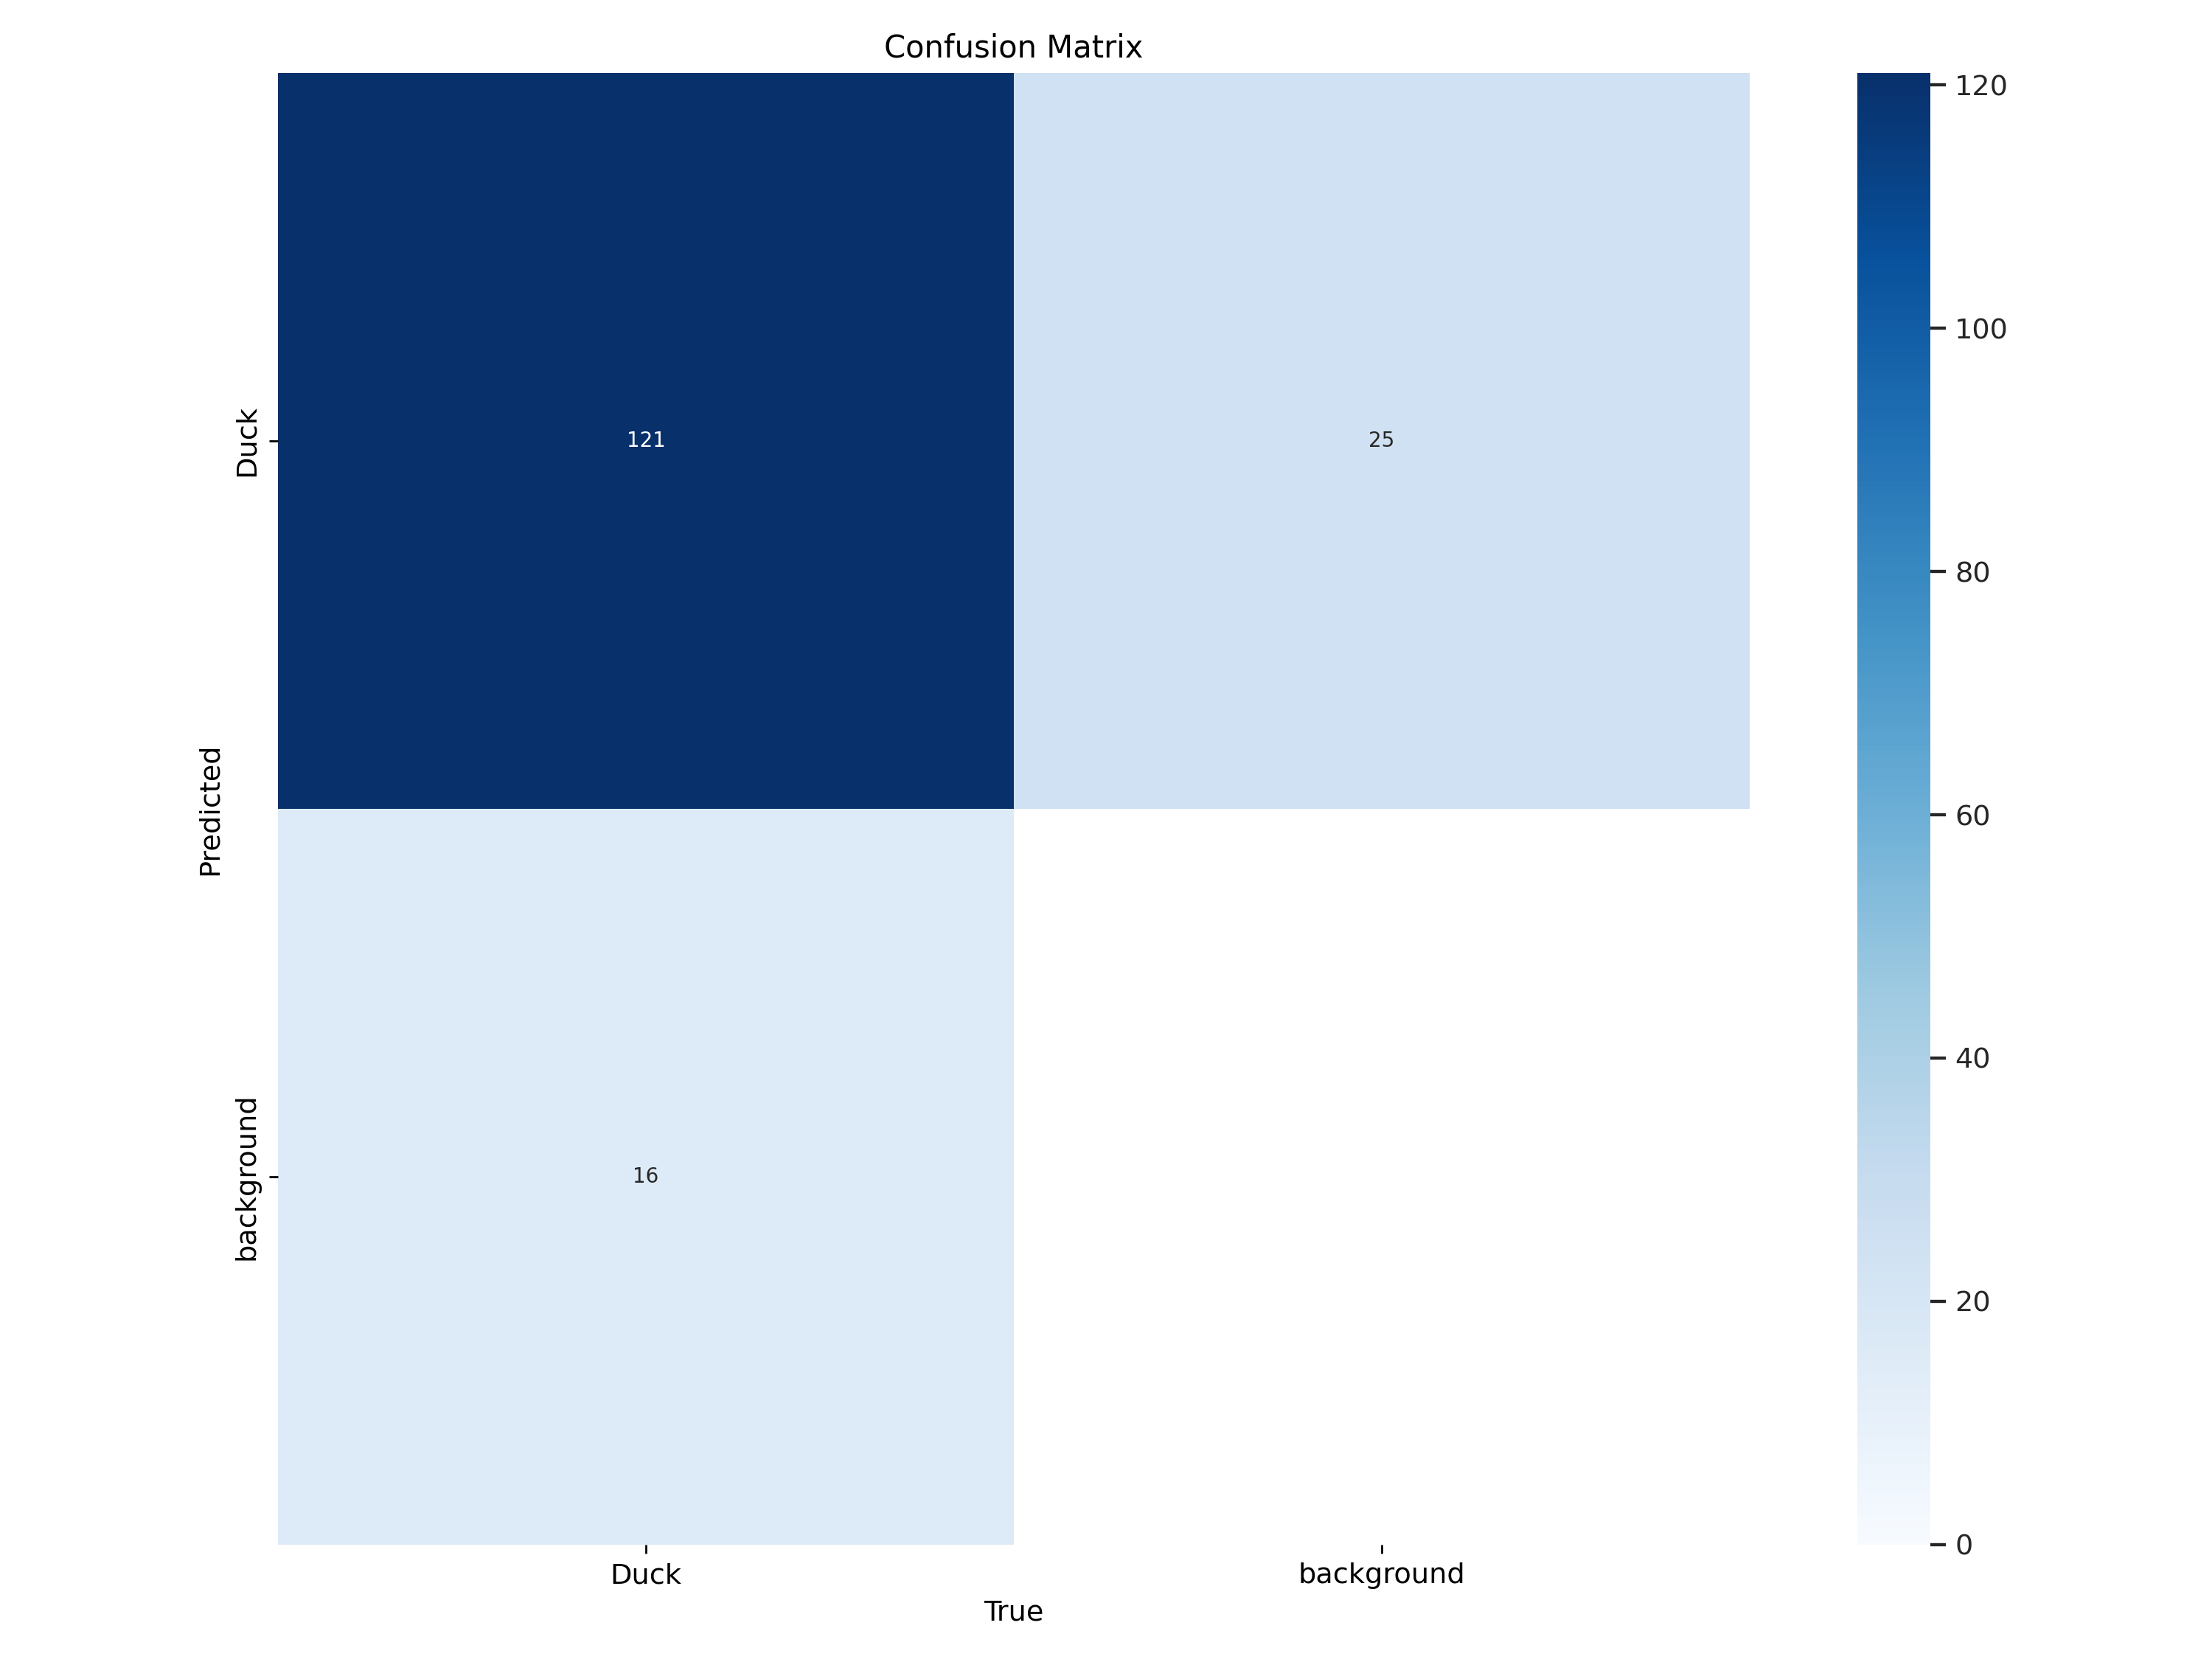

In [ ]:
from IPython.display import Image
Image(filename=f"/content/runs/segment/train/confusion_matrix.png", width=1000)

# **Analyzing Model Training Details - Batch Data with class id**

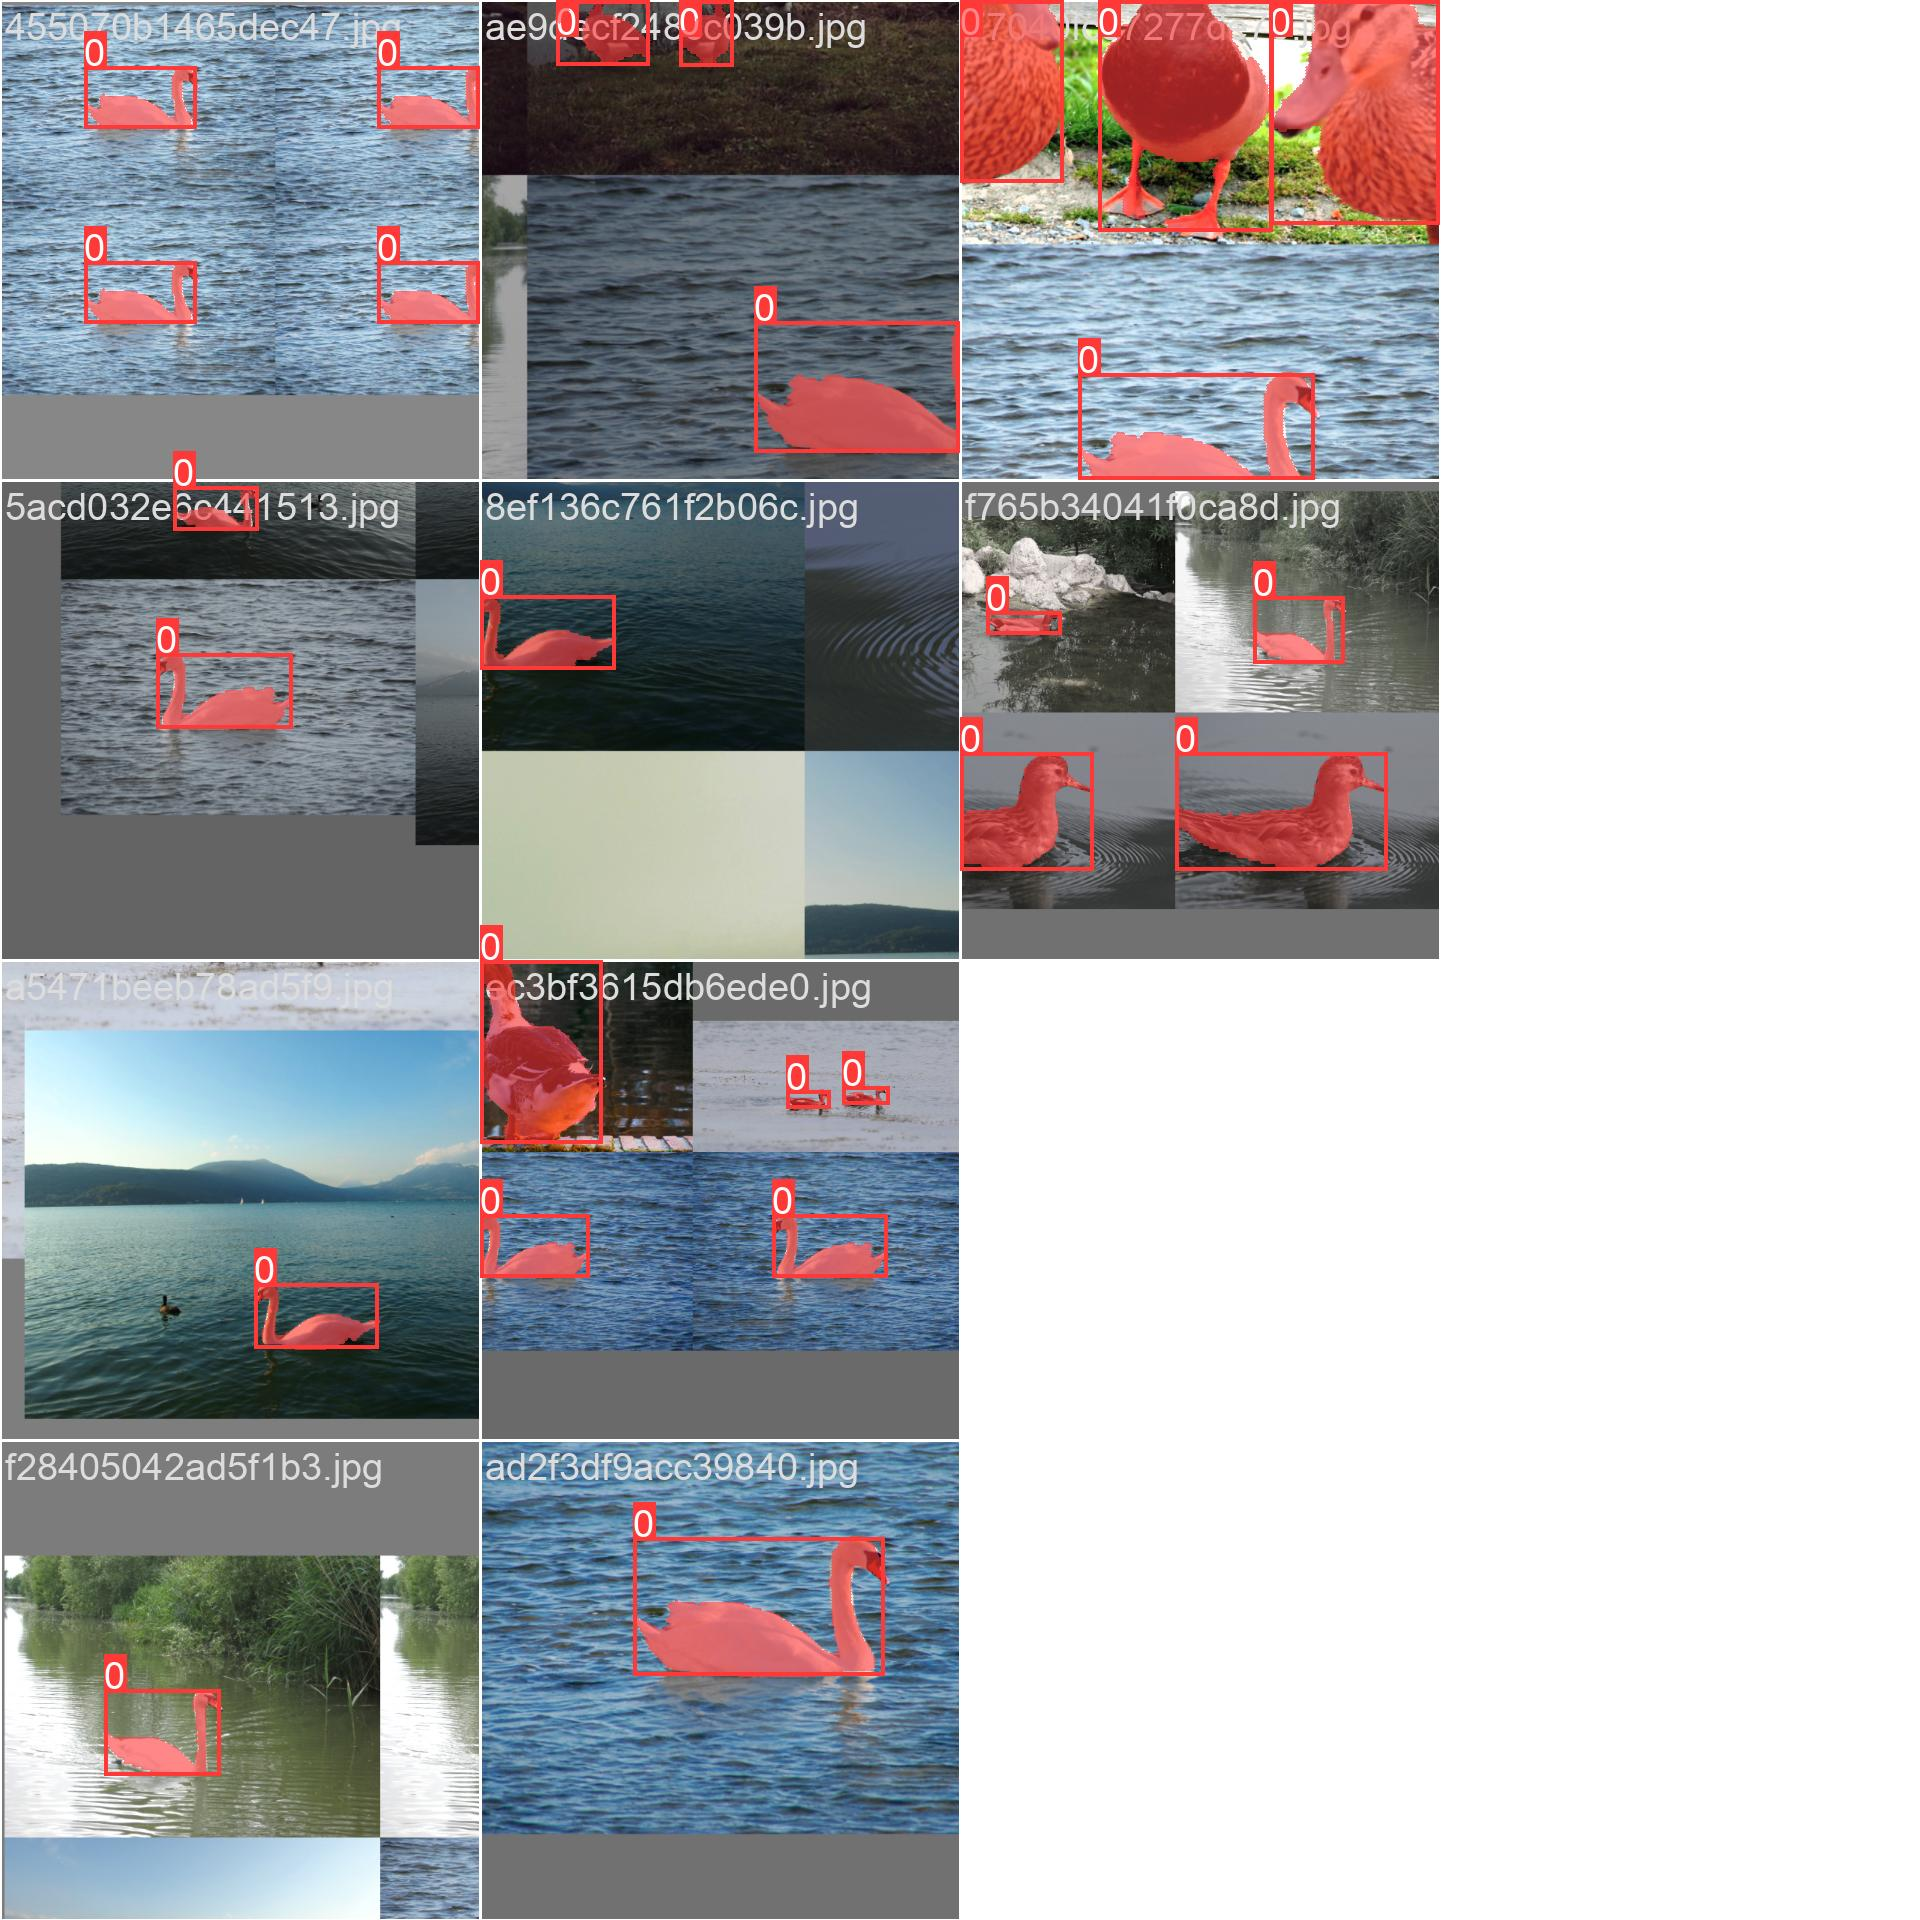

In [ ]:
from IPython.display import Image
Image(filename=f"runs/segment/train/train_batch0.jpg", width=1000)

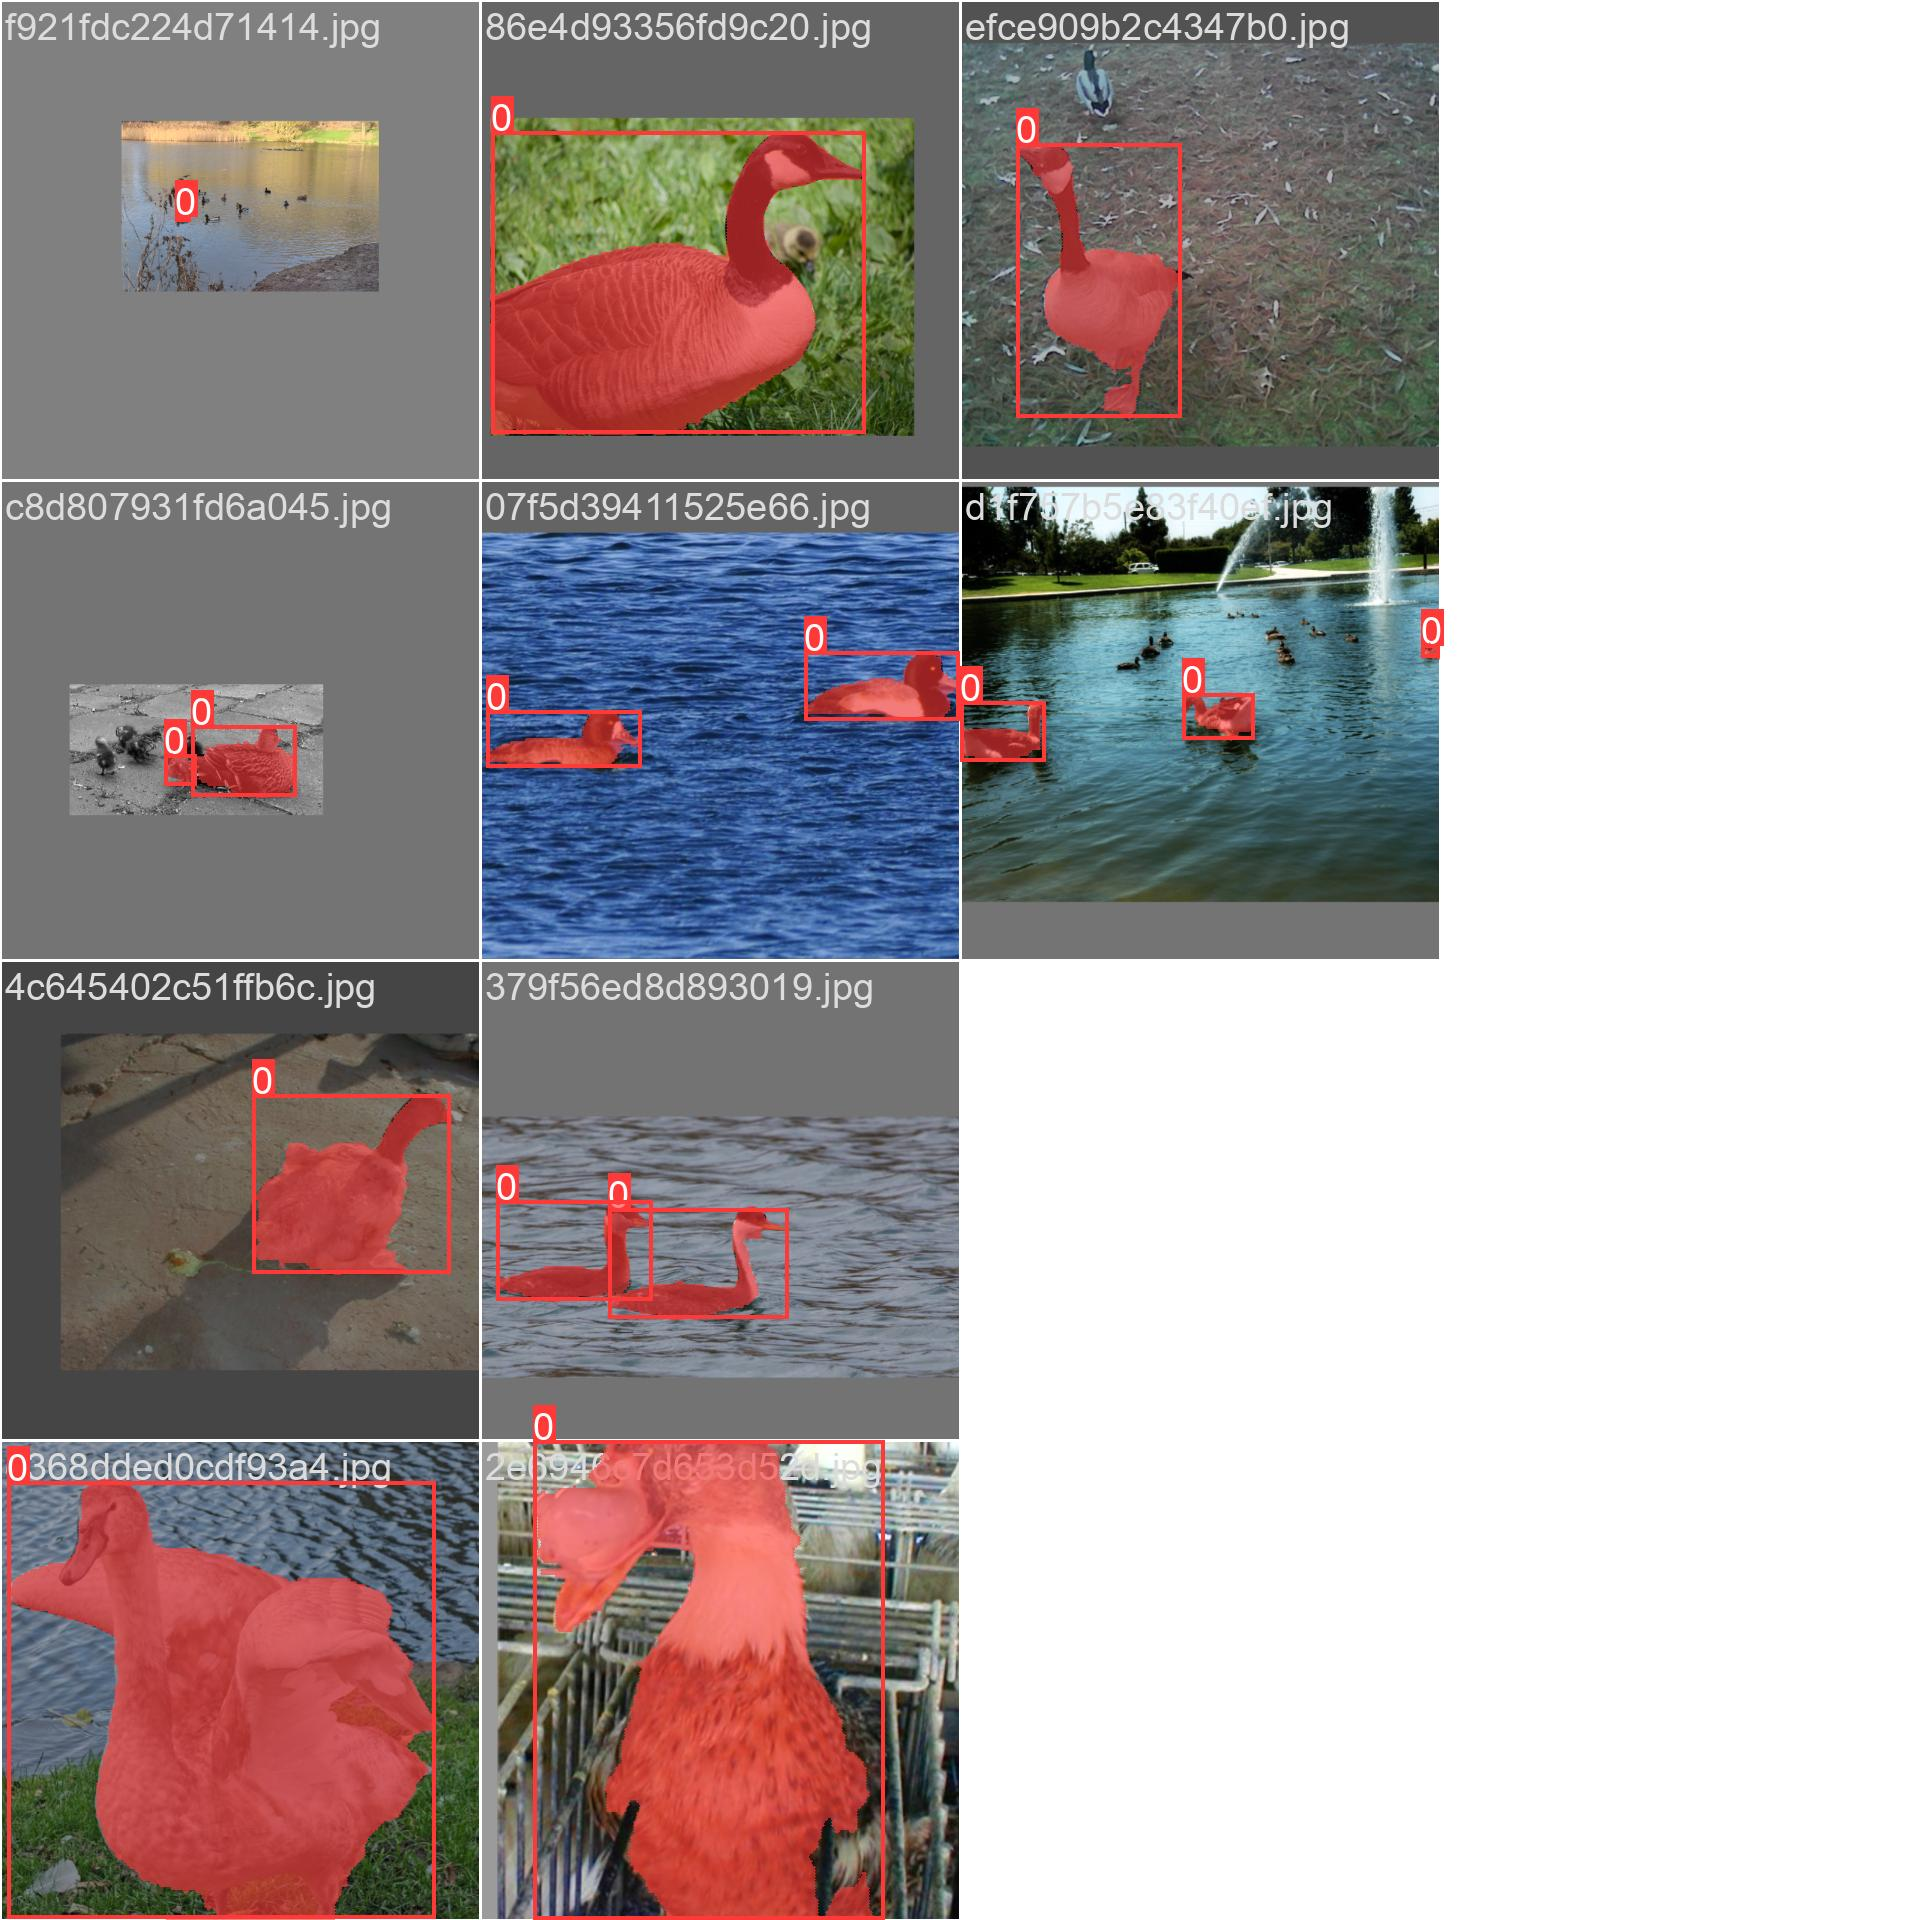

In [ ]:
Image(filename=f"runs/segment/train/train_batch7942.jpg", width=1000)

# **Analyzing Model Training Details - Batch Data with Correct Labels Prediction**

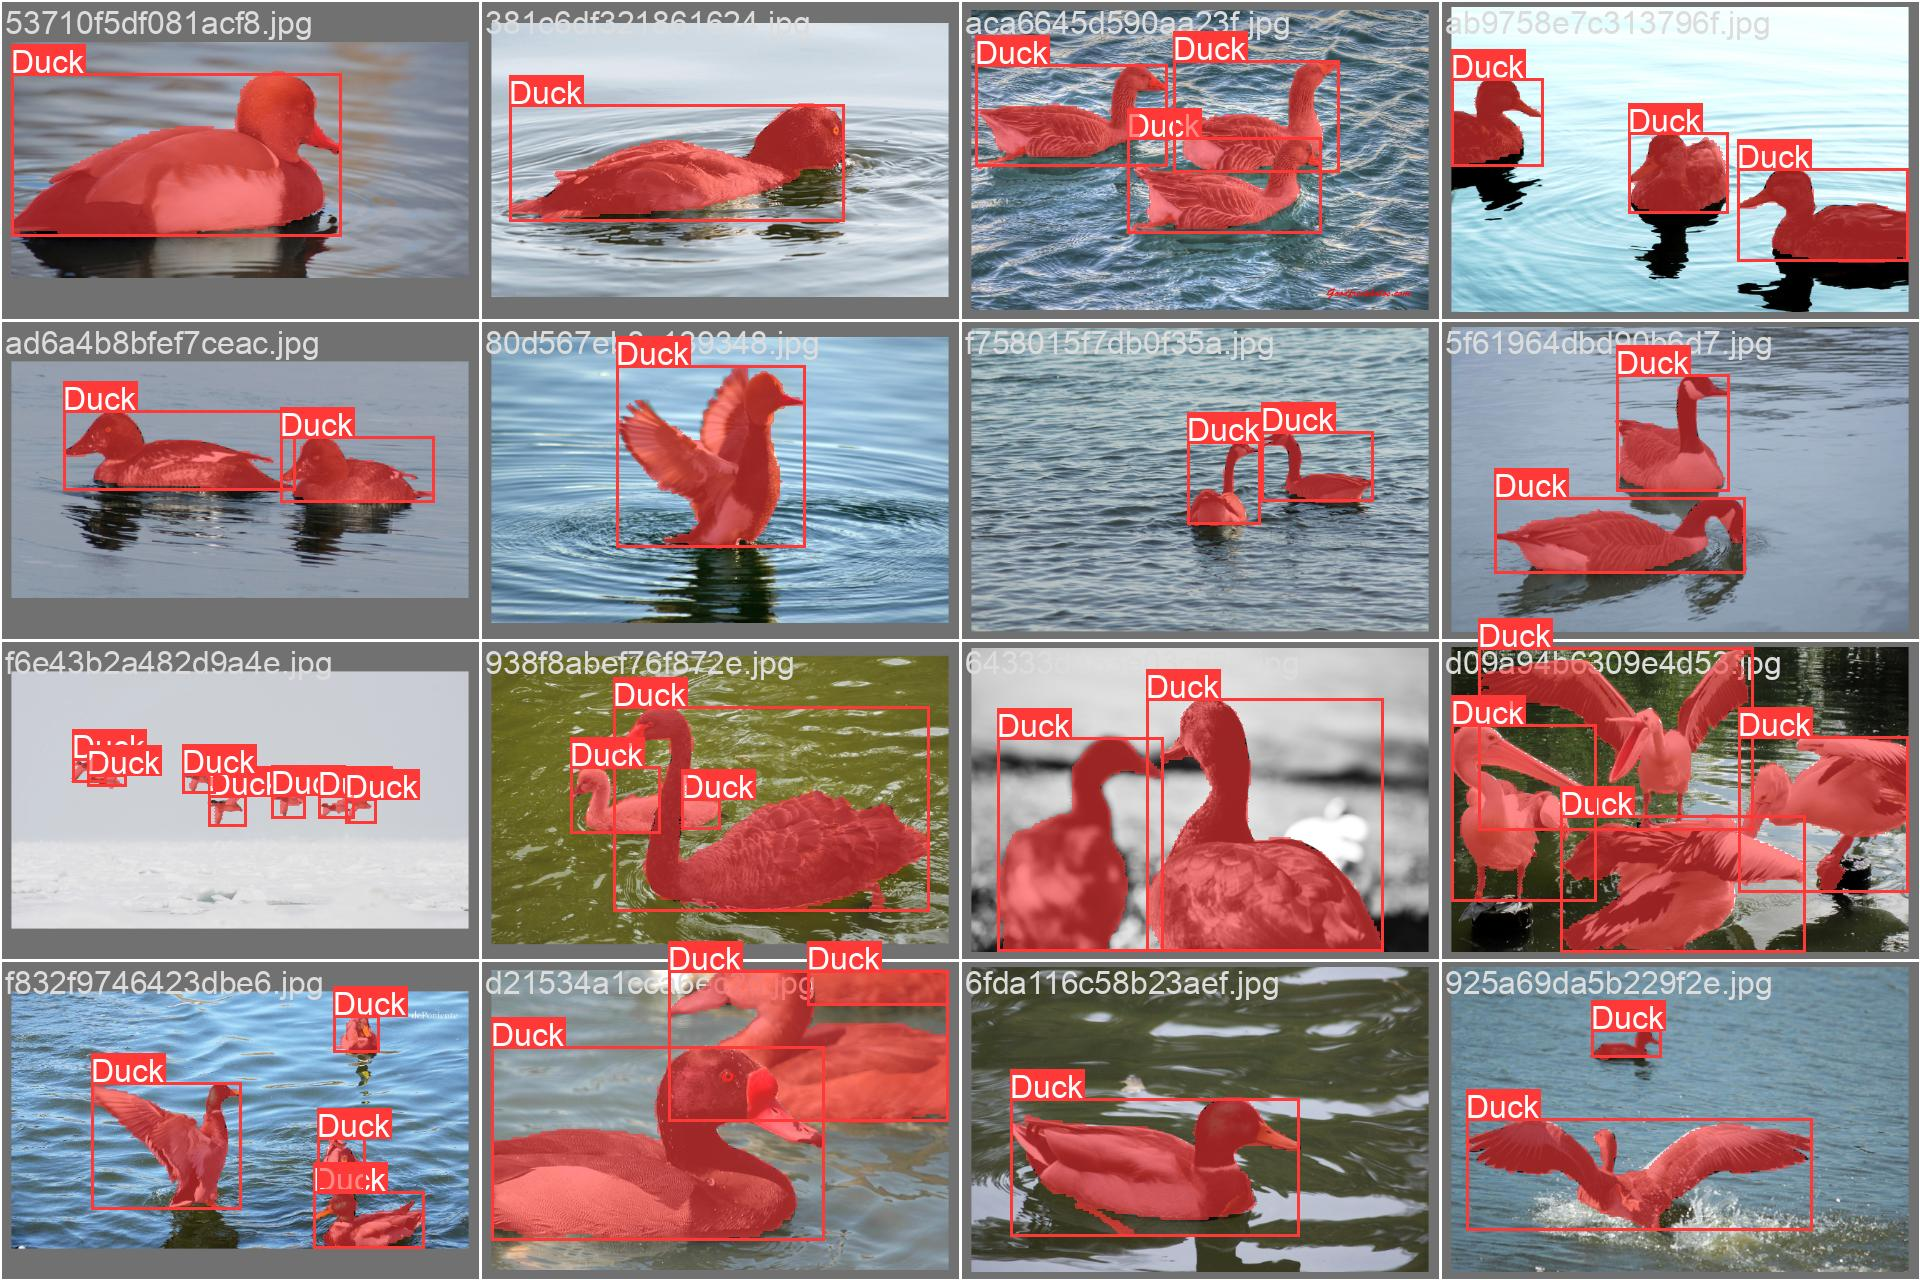

In [ ]:
Image(filename=f"runs/segment/train/val_batch0_labels.jpg", width=1000)

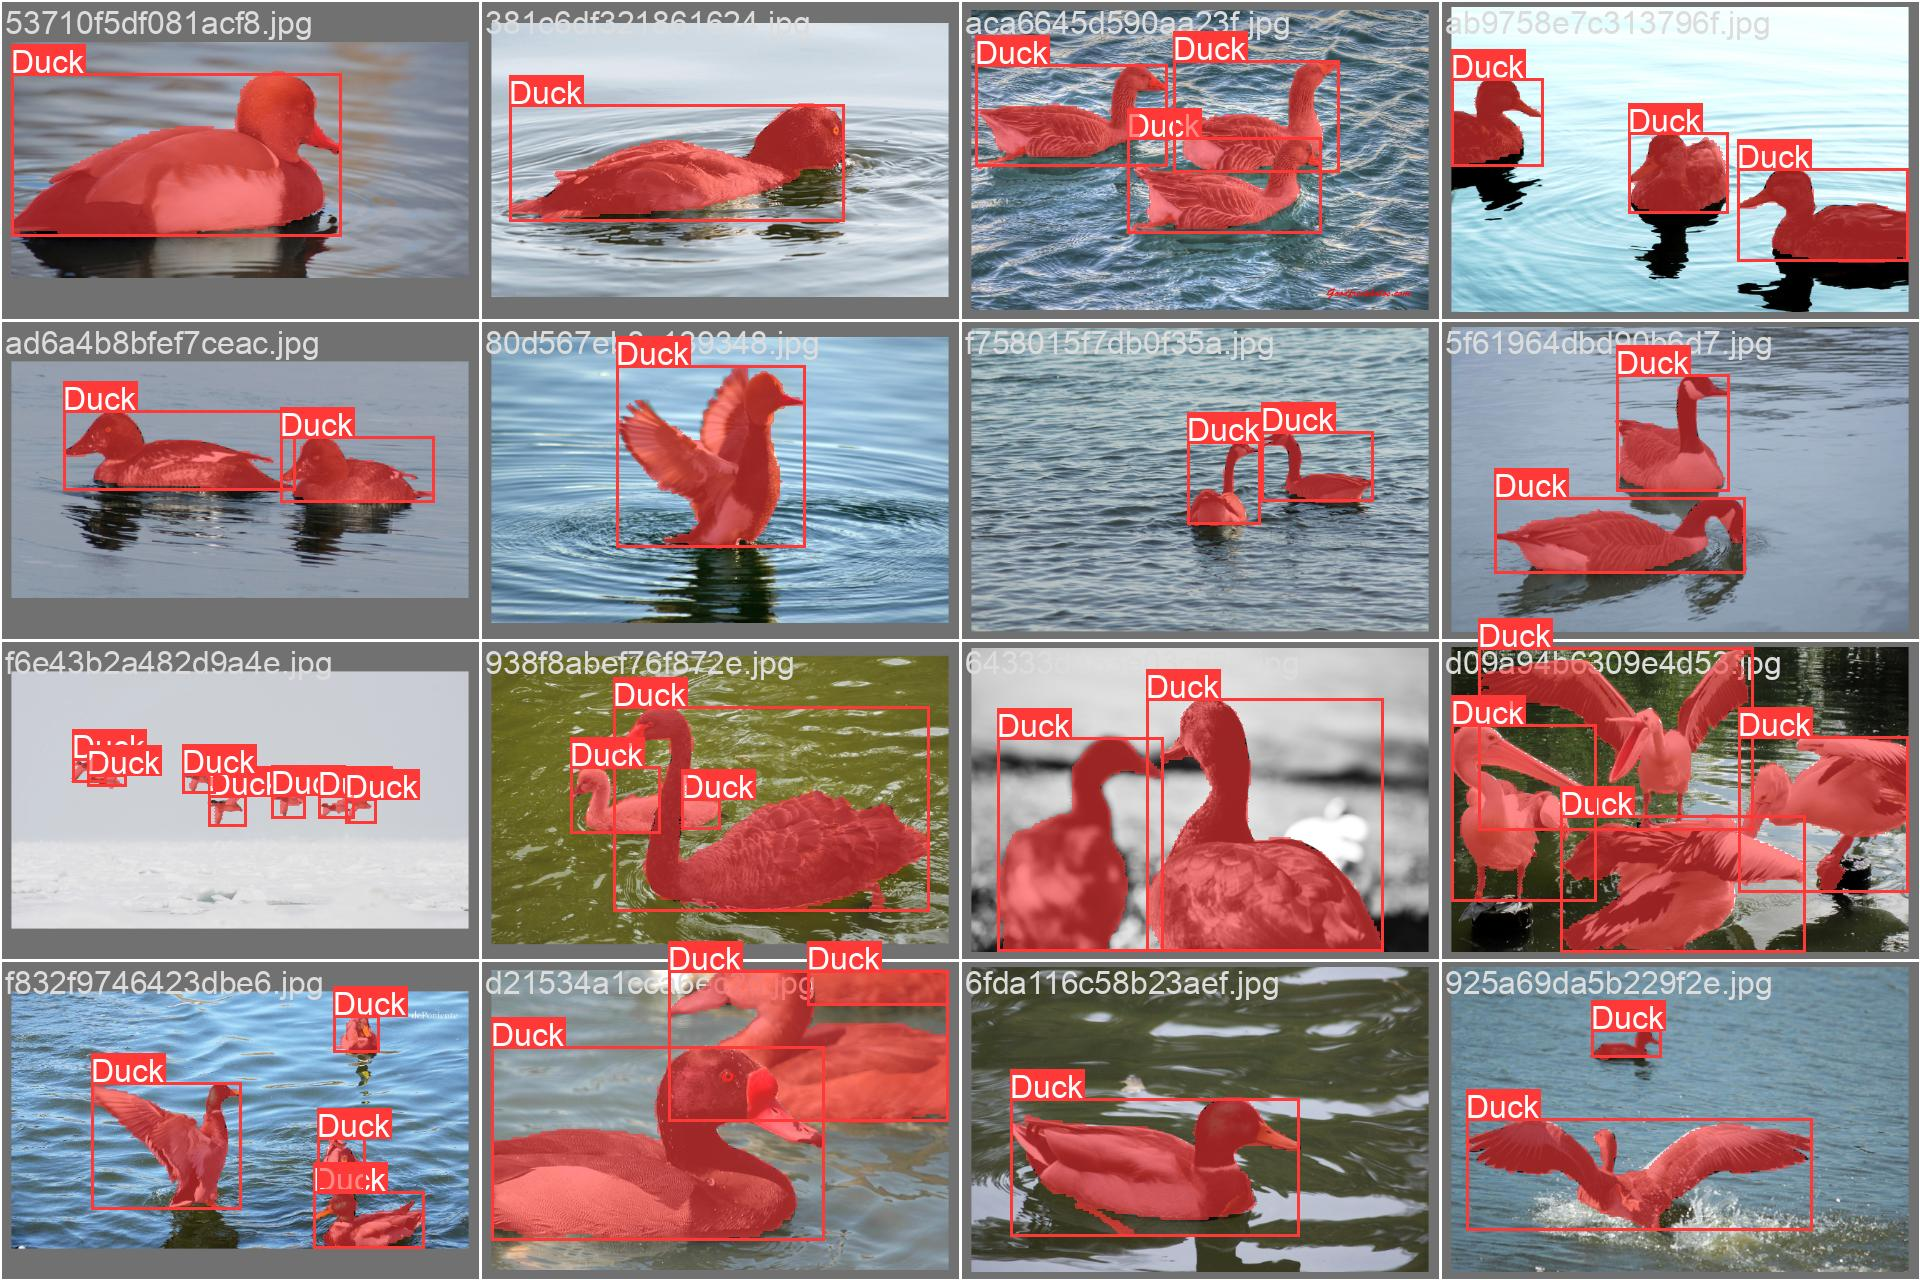

In [ ]:
from IPython.display import Image
Image(filename=f"runs/segment/train/val_batch0_labels.jpg", width=1000)

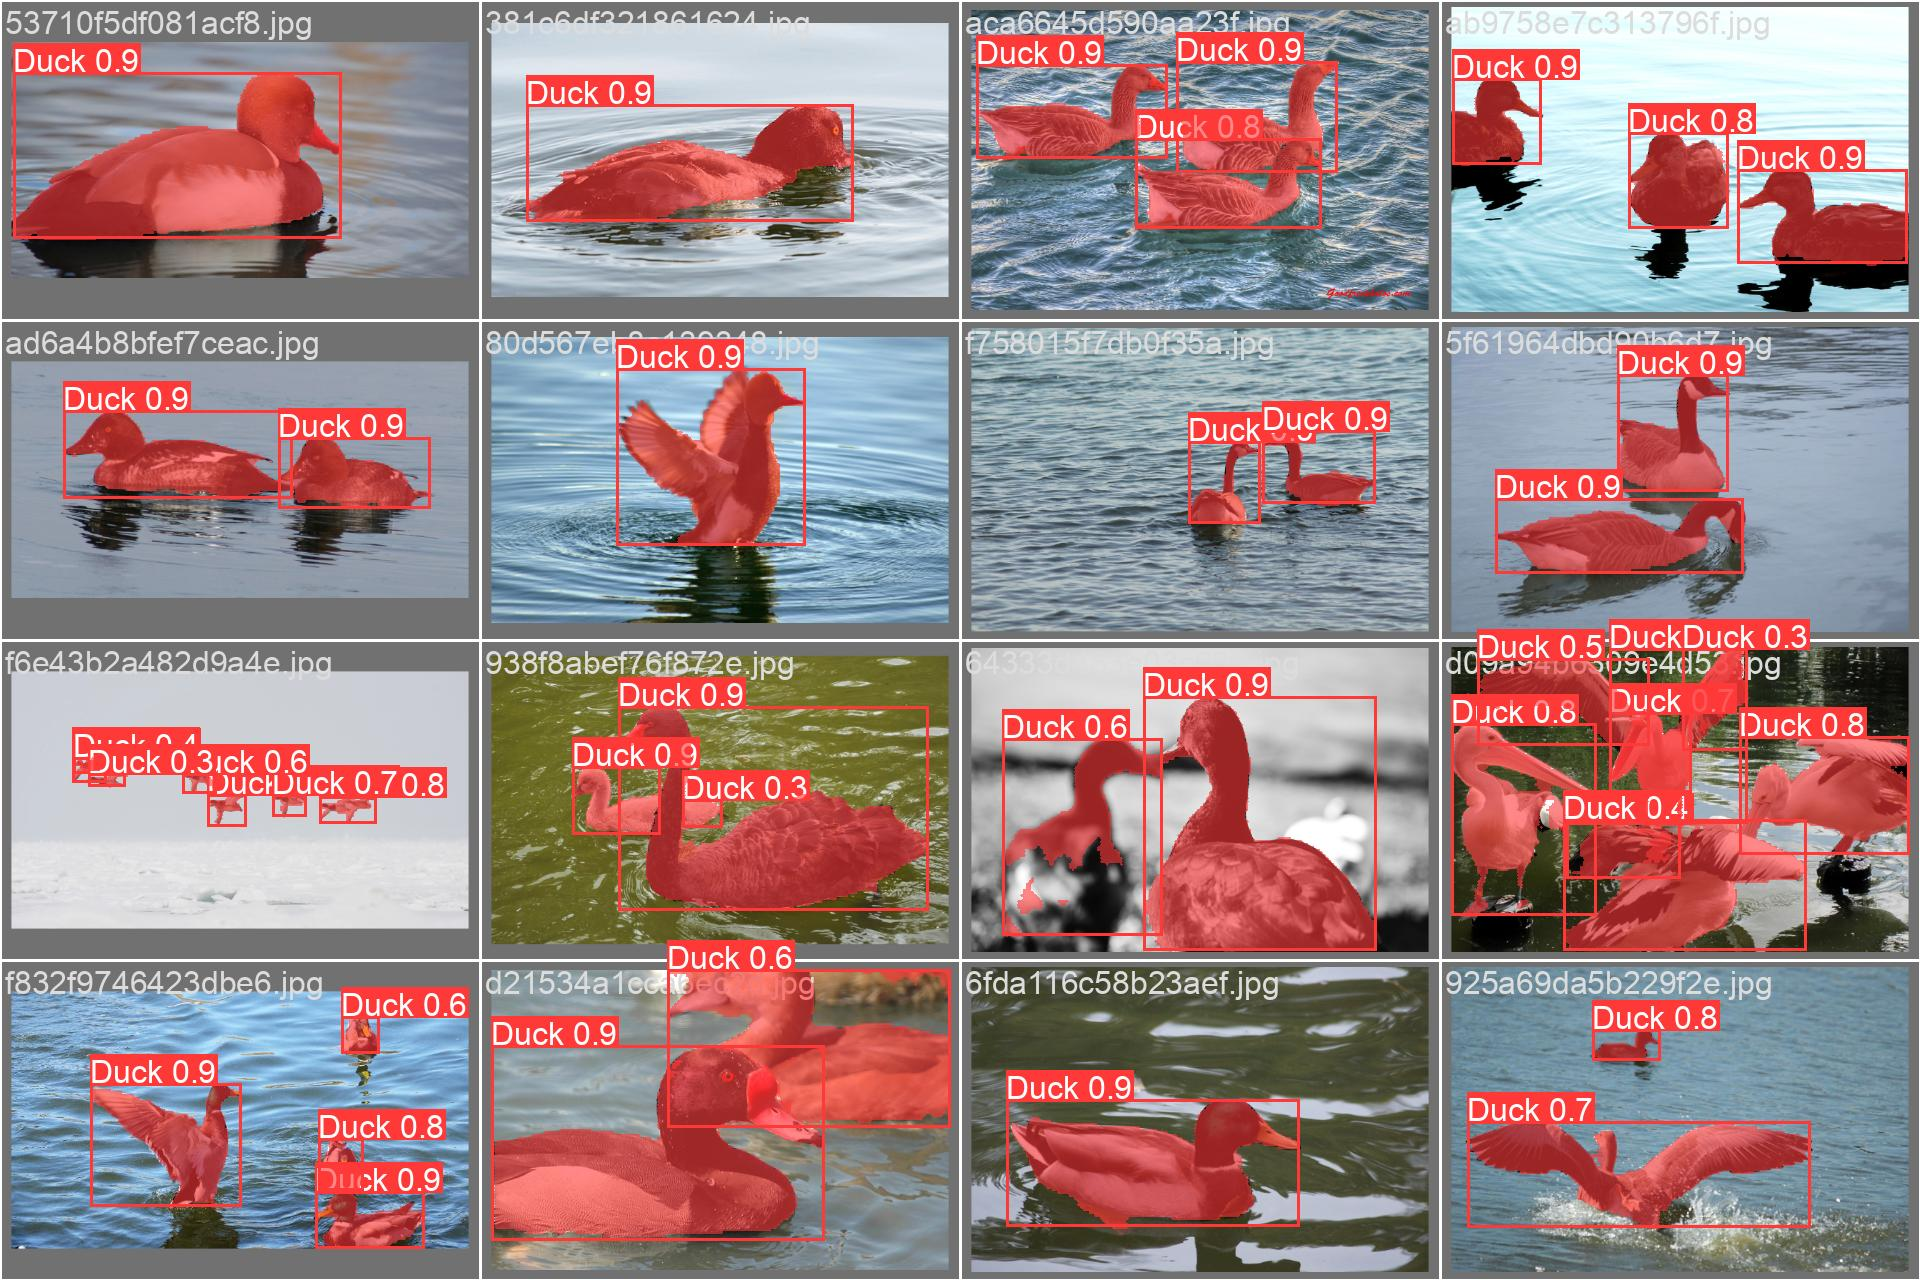

In [ ]:
from IPython.display import Image
Image(filename=f"runs/segment/train/val_batch0_pred.jpg", width=1000)

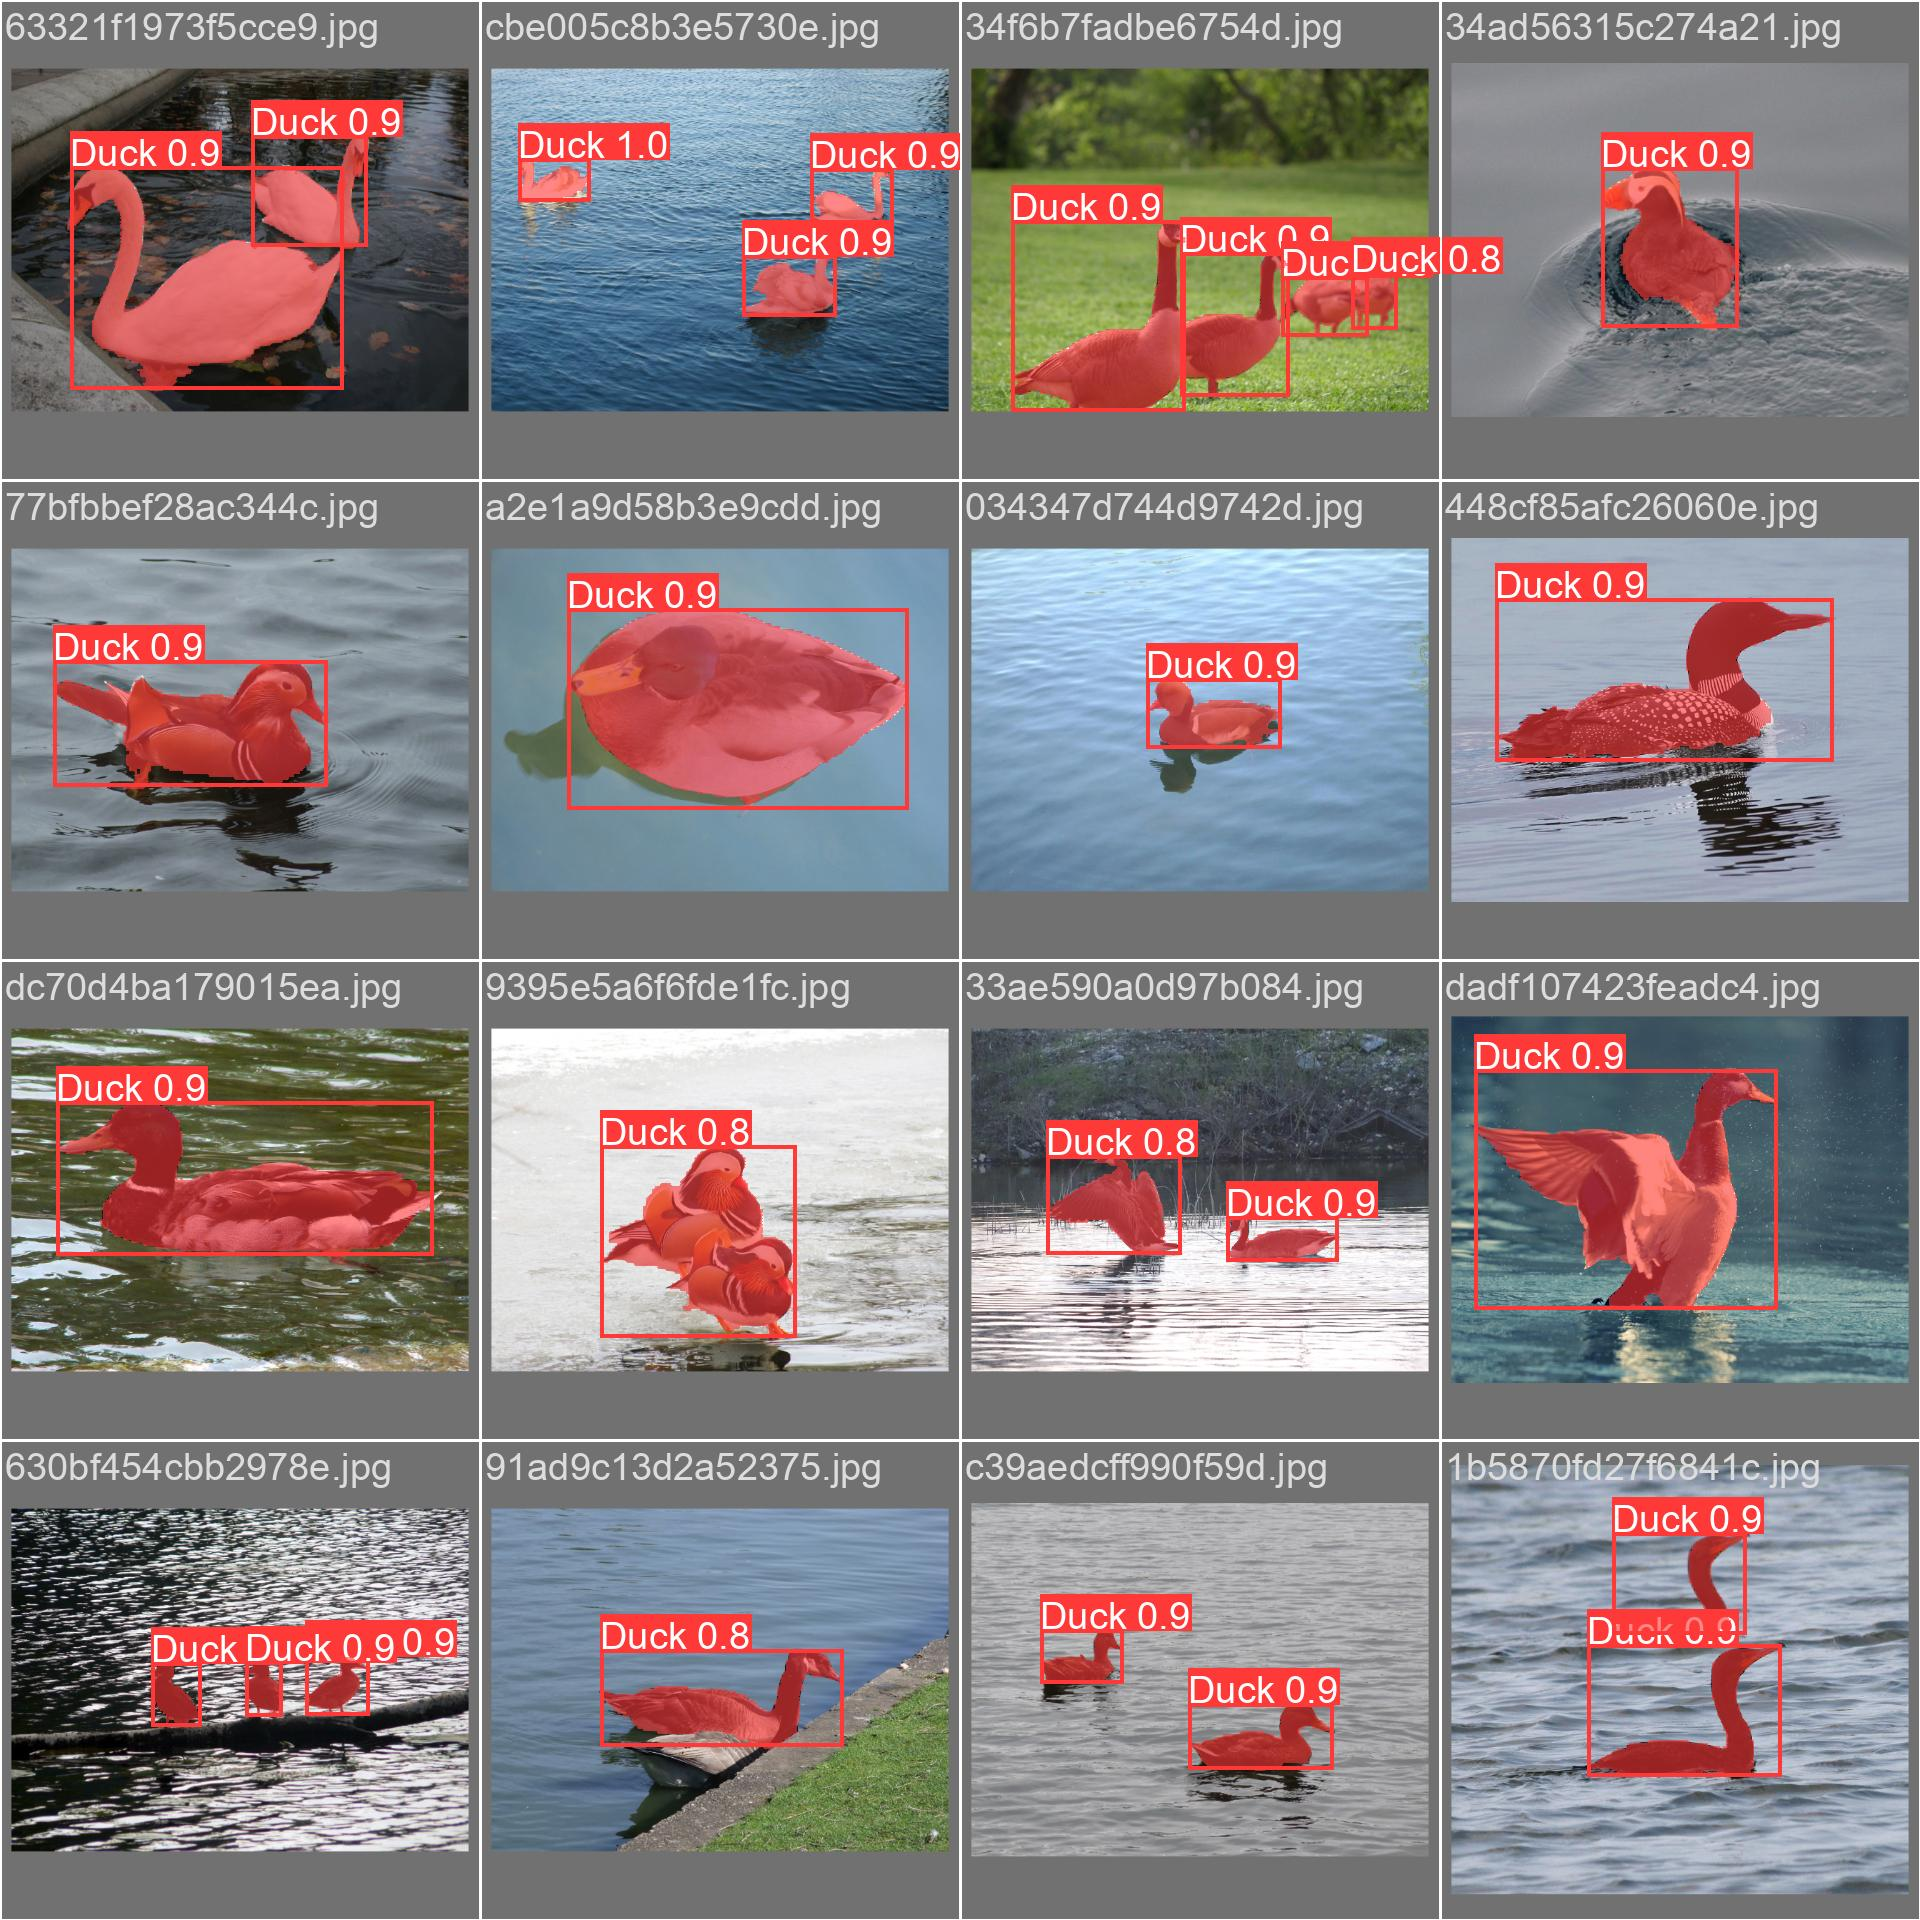

In [ ]:
from IPython.display import Image
Image(filename=f"runs/segment/train/val_batch2_pred.jpg", width=1000)

# **Copy the Analyzing Data to my Google Drive for Later Usage**

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Step 2: Use Python to Copy the File
import shutil
import os

# Define the paths
source_path = '/content/run.zip'
destination_path = '/content/gdrive/MyDrive/semantic_yolo/run.zip'

# Ensure the destination directory exists
destination_dir = os.path.dirname(destination_path)
os.makedirs(destination_dir, exist_ok=True)

# Copy the file
shutil.copy(source_path, destination_path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive/semantic_yolo/run.zip'

# **Testing Prediction :: Checking with main downloaded data using yolo if it can predict**

In [ ]:
import cv2
import torch
from ultralytics import YOLO

# Define paths
model_path = '/content/runs/segment/train/weights/last.pt'
image_path = '/content/data/images/test/01211d4bbc161694.jpg'

# Load image
img = cv2.imread(image_path)
H, W, _ = img.shape

# Load YOLO model
model = YOLO(model_path)

# Run inference
results = model(img)

# Process results
for result in results:
    for j, mask in enumerate(result.masks.data):
        #mask = mask.numpy() * 255. //This code gives error in google colab with cuda
        # Move mask to CPU and convert to NumPy
        mask = mask.cpu().numpy() * 255

        # Resize mask to match original image dimensions
        mask = cv2.resize(mask, (W, H))

        # Save the mask
        cv2.imwrite(f'./output_{j}.png', mask)



0: 416x640 1 Duck, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 640)
